# PyTorch Homework
## 作業說明
這個作業希望以 PyTorch 的框架透過實作讓同學了解基本的讀取資料集、搭建模型以及訓練的過程。

這次作業分成三大部份及若干小部份，有一些**被註解框起來的區域**以及 **?** 的部份需要完成。

1. **資料準備 - 30%**
    + Transformation
    + Custom dataset definition - 10%
    + Create datasets - 10%
    + Create dataloaders - 10%


2. **建立模型 - 35%**
    + flatten function - 5%
    + 使用 nn.Module 建立模型 - 10%
    + 使用 nn.Sequential 建立模型 - 10%
    + 自己設計模型 - 10%
    

3. **訓練模型 - 35%**
    + Loss function & optimizer - 5%
    + 訓練 - 20%
        + 完成程式碼 - 10%
        + 自行設計的模型測試集準確率(只看最後 5 個 epoch 中的 best accuracy) - 10%
            + 達到 50% baseline - 5%
            + Bonus: 準確率超過 baseline 越多拿越高 - 5% 
    + 儲存模型 - 5%
    + 繪製 loss 及 accuracy 圖表 - 5%

## 作業繳交
1. 繳交期限：


2. 繳交方式：
    
    只需繳交這份完成的 ipynb 檔至 moodle，每個 cell 的執行結果都要顯示出來(訓練過程、loss curves 等等)，會用這些結果評分，不需要上傳訓練好的模型。
    
    檔案命名格式：學號_姓名_hw2.ipynb (ex: F12345678_王大明_hw2.ipynb)
    * **格式不對的話會扣 10 分！！！**
    

3. 有問題請寄信至助教信箱 ne6094041@gs.ncku.edu.tw 或於 TA hour 至資訊新館65601室找助教詢問。
    + TA hour: 星期一和四 14:00 ~ 16:30

## Import

In [1]:
import os
import os.path as osp

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from torchviz import make_dot
%matplotlib inline

## Hyperparamters
可以自行新增或調整需要的 hyperparameter

In [2]:
SEED = 42

# data
DATA_PATH = 'stanford_dog'
BATCH_SIZE = 32
NUM_WORKERS = 4
MEAN, STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) # mean and std for ImageNet

# training
LR = 1e-3
EPOCHS = 40
USE_CUDA = True # use cuda or not
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
PRINT_FREQ = 10

## GPU Setting
用 ```torch.cuda.is_available()``` 測試系統是否能使用 cuda

In [3]:
device = 'cpu'
if USE_CUDA and torch.cuda.is_available(): # 若想使用 cuda 且可以使用 cuda
    device = 'cuda:1'
print(f'Using {device} for training.')

Using cuda:1 for training.


## 1. Preparing Dataset
PyTorch 中處理資料的部份主要由兩種 API 組成:
+ ```Dataset```: 定義如何讀取資料，並對資料做前處理(搭配 ```transforms```)
+ ```DataLoader```: 負責將多個樣本打包成 mini-batch 、處理資料取樣、以 multi-threading 或 multi-processing 的方式讀取資料等等

### 1.1 Transformations
Pytorch 的 ```transforms``` API 包含許多常用的方法，如縮放、剪裁、翻轉、旋轉、自定義 transform 等等，也包含不同影像格式之間與 tensor 的型態轉換。

每個 transform 方法可以單獨地被套用在影像上，也可以使用 ```Compose()``` 將許多方法組合在一起，並且會自動地照組合順序套用在影像上

這裡的 transformations 是常見且基本的組合，雖然這裡不需要填寫，但你可以在裡面增加一些 augmentation 幫助後面的模型訓練。

In [4]:
normalize = transforms.Normalize(mean=MEAN, std=STD)

# a set of common trasnformation combination for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

# transformations for testing do not need to do fancy tricks
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

### 1.2 定義 dataset
自定義的資料集會繼承 ```Dataset```，並且 overwrite 以下 3 個 function:
1. ```__init__```: 建立資料集中樣本的讀取路徑以及 label 清單
2. ```__len__```: 回傳資料集大小，即樣本的數量
3. ```__getitem__```: 實際讀取資料的 function ，根據給定的 index 讀取影像，並對影像進行 transformation ，最後回傳處理過的影像以及其 label 。

在這裡，我們會將每張影像的讀取路徑儲存在 ```samples``` 裡，其對應的 label 儲存在 ```labels```中。

請完成以下 ? 處以及被註解框起來的區域。

In [5]:
class DogDataset(Dataset):
    def __init__(self, samples, classes, cls_to_idx, transform=None):
        """
        samples: 儲存每張影像的路徑以及 label 的清單
        classes: 所有類別名稱的清單
        cls_to_idx: 類別和對應 index 的 dict
        transform: 要對影像執行的 transformation
        """
        self.transform = transform
        
        self.classes = classes
        self.cls_to_idx = cls_to_idx
        self.targets = [s[1] for s in samples] # list of labels corresponding to samples
        self.samples = [s[0] for s in samples] # list of sample paths
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        path = self.samples[idx]
        label = self.targets[idx]
    
        # load the image using PIL.Image.open()
        img = Image.open(path)
        
        img = self.transform(img)

        return img, label

### 1.3 Create datasets
首先找出所有資料的路徑並儲存成清單

這裡不用填寫，但需要執行。

In [6]:
def find_files(folder):
    """
    Getting the list of files and their labels.
    
    Returns:
    classes: list of class names
    cls_to_idx: dict that map class names to their interger labels
    instances: dict that uses labels as keys and the corresponding tuples (samples, # of samples) as values
    """
    # find classes under the folder
    folder_path = os.path.expanduser(folder)
    classes = os.listdir(folder_path) # class list
    cls_to_idx = {name: i for i, name in enumerate(classes)} # {class name: index}
        
    # find files and make list of them
    instances = {}
    for cls in sorted(cls_to_idx.keys()):
        cls_idx = cls_to_idx[cls]
        cls_path = osp.join(folder_path, cls) # path to the class folder
        files = [ f for f in os.listdir(cls_path) if f[-3:]=="jpg"]  # list of images under the class
        items = [(osp.join(cls_path, name), cls_idx) for name in files] # combine them to form complete paths
        instances[cls_idx] = (items, len(items)) # (list of samples of the class, num of images in this class)
        
    return classes, cls_to_idx, instances

# get the list of samples under the folder
classes, cls_to_idx, instances = find_files(DATA_PATH)
print(f'There are {len(classes)} classes and {sum([s[1] for s in instances.values()])} images.')

There are 20 classes and 3633 images.


#### Split dataset
若資料集本身沒有區分訓練集、驗證集或測試集，我們就必須手動分割出這些子集。

這次作業採用「訓練集:測試集 = 8:2」的分割策略，對每個類別中的樣本都採用這個比例，這裡使用 ```sklearn``` 的 ```train_test_split``` 。

請完成以下 ? 處以及被註解框起來的區域。

In [18]:
train_samples = []
test_samples = []

# iterate through all classes, split the samples and store them in the lists
for cls_idx, cls_samples in instances.items():
    train, test = train_test_split(cls_samples[0], test_size=0.2, random_state=SEED)  # split
    train_samples += train
    test_samples += test
    
train_dataset = DogDataset(train_samples,classes,cls_to_idx,transform=train_transforms)
test_dataset = DogDataset(test_samples,classes,cls_to_idx,transform=test_transforms)
   
print('Size of train dataset: %d, size of test dataset: %d' % (len(train_dataset), len(test_dataset)))

7
3
18
13
4
12
6
8
11
14
2
0
16
17
9
5
15
10
1
19
Size of train dataset: 2898, size of test dataset: 735


### 1.4 Create dataloaders
```DataLoader``` 負責將從 dataset 中得到的東西根據採樣策略 (```sampler```)、batch size 大小 (```batch_size```)、是否打亂資料順序 (```shuffle```)（訓練時通常會打亂），將樣本打包成一個 mini-batch ，並根據 ```num_workers``` 調整讀取資料的所需的資源。

從 dataloader 中讀取資料的方式為像 python generator 或 list 一樣使用迴圈取出資料，可以在後面的訓練階段中看到。

請完成以下被註解框起來的區域。

In [8]:
train_loader = None
test_loader = None  

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,num_workers=4)   
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,num_workers=4)   

print(f'There are {len(train_loader)} training batches and {len(test_loader)} testing batches')

There are 91 training batches and 23 testing batches


## 2. Model
PyTorch 的模型（包括基本的 conv, batchnorm 層等等）大部分都是繼承 ```nn.Module```，並且都具備 
+ ```__init__```: 定義內部結構，例如 conv, pool 等等。
+ ```forward```: 定義前面的結構操作如何串聯，也就是這些結構的順序，是輸入的張量真正進行計算的 function 。

用來建立模型的 API 有很多種，包括 ```nn.Module```、```nn.Sequential```、```nn.ModuleList```、```nn.ModuleDict``` 等等。

這次作業要求以前兩種方法建立模型，分成 2.1 以及 2.2，並在這兩個部分裡完成下面所敘述的模型結構：
1. A convolution layer with 64 11*11 filters, stride 4 and padding 2
2. ReLU
3. A Maxpooling layer with 3*3 kernel and stride 2
4. A convolution layer with 128 5*5 filters and padding 2
5. ReLU
6. A Maxpooling layer with 3*3 kernel and stride 2
7. A convolution layer with 256 3*3 filters and padding 1
8. ReLU
9. A convolution layer with 128 3*3 filters and padding 1
10. ReLU
11. A convolution layer with 128 3*3 filters and padding 1
12. ReLU
13. A Maxpooling layer with 3*3 kernel and stride 2
14. flatten
15. A fully-connected layer that outputs tensor to 1024
16. ReLU
17. A fully-connected layer that outputs tensor to 256
18. ReLU
19. A fully-connected layer that outputs tensor to 20

### 2.1 flatten function
Flatten 作用是將 tensor 除了 batch 以外的其他維度全部攤平。

請完成以下被註解框起來的區域。

In [9]:
def flatten(x):
    x = torch.flatten(x ,  start_dim = 1 )
    return x

### 2.2 使用 nn.Module 建立模型
如同一般定義 python class 的方法，在建構子中定義會用到的 layer ，並在 forward 中定義其之間的操作連結。

請完成以下被註解框起來的區域。

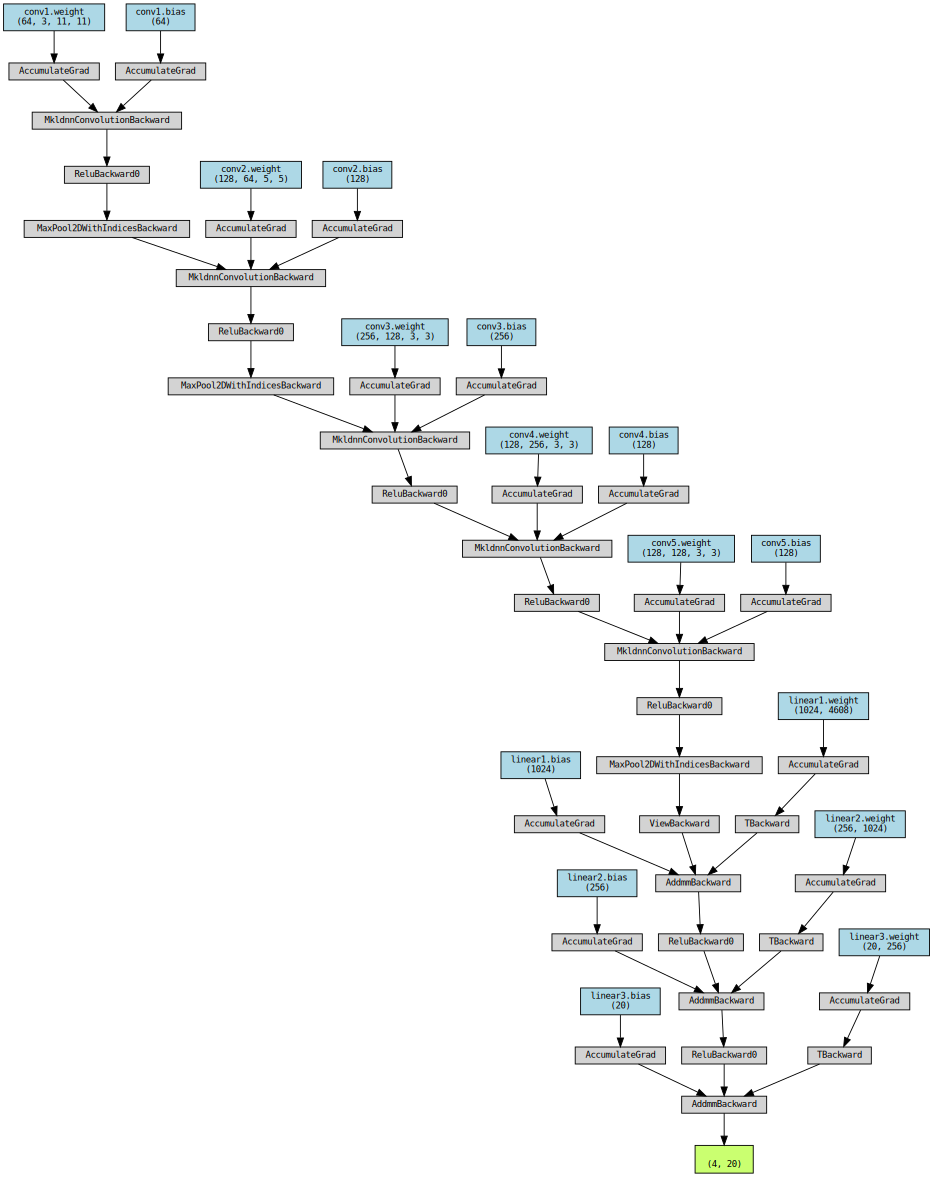

In [10]:
import torch.nn.functional as F

class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__() # this line must be done first
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=2)   
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,padding=2)
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1)
        
        self.linear1 = nn.Linear(4608,1024)
        self.linear2 = nn.Linear(1024,256)
        self.linear3 = nn.Linear(256,20)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2)     
    
    def forward(self, x):
        
        # 1~3
        x = self.maxpool(F.relu(self.conv1(x)))
        
        # 4~6
        x = self.maxpool(F.relu(self.conv2(x)))
        # 7-8
        x = F.relu(self.conv3(x))
        # 9~10
        x = F.relu(self.conv4(x))
        # 11~12
        x = F.relu(self.conv5(x))
        # 13
        x = self.maxpool(x)
        # 14
        x = flatten(x)
        # 15~16
        x = F.relu(self.linear1(x))
        # 17~18
        x = F.relu(self.linear2(x))
        # 19
        x = self.linear3(x)
        return x 

x = torch.randn(4, 3, 224, 224)
model = TestModel()

make_dot(model(x), params=dict(model.named_parameters()))
# 可以將畫出來的圖與助教提供的圖對比看看是否一樣或十分相似

### 2.3 使用 nn.Sequential 建立模型
```nn.Sequential``` 的不同之處在於可以直接從一系列的 layer 建立模型，不需定義 ```__init__``` 也不用定義 ```forward``` ，會自動依序用每一層進行 forward ，相對地，其成員皆需有 ```forward``` 可以呼叫。

請完成以下被註解框起來的區域。

In [11]:
# wrap the flatten function
'''
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model = None
model = nn.Sequential( 
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),      
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),  
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(),        
            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(),            
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(),                  
            nn.MaxPool2d(kernel_size=3,stride=2), 
            Flatten(),
            nn.Linear(4608,1024),
            nn.ReLU(),       
            nn.Linear(1024,256),
            nn.ReLU(),       
            nn.Linear(256,20)
        )
    
x = torch.randn(4, 3, 224, 224)
make_dot(model(x), params=dict(model.named_parameters()))
# 可以將畫出來的圖與助教提供的圖對比看看是否一樣或十分相似

'''

'\nclass Flatten(nn.Module):\n    def forward(self, x):\n        return flatten(x)\n\nmodel = None\nmodel = nn.Sequential( \n            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4,padding=2),\n            nn.ReLU(),\n            nn.MaxPool2d(kernel_size=3,stride=2),      \n            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,padding=2),\n            nn.ReLU(),\n            nn.MaxPool2d(kernel_size=3,stride=2),  \n            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),\n            nn.ReLU(),        \n            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1),\n            nn.ReLU(),            \n            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),\n            nn.ReLU(),                  \n            nn.MaxPool2d(kernel_size=3,stride=2), \n            Flatten(),\n            nn.Linear(4608,1024),\n            nn.ReLU(),       \n            nn.Linear(1024,256),\n            nn.

### 2.4 自行設計模型
請使用上述任一種方式設計自己的模型(實體化後的模型名稱為 ```mymodel```)，並解釋自己的設計。最後的分類為 20 個類別。

## **不可以直接呼叫```torchvision.models```中已經寫好的模型，但可以照著論文中的模型架構手刻出來**

## **不可以使用預訓練過的模型權重作為初始狀態，也就是不能用預訓練的模型再 fine-tune**

請完成以下被註解框起來的區域。

In [12]:
#mymodel = None
#x = torch.randn(4, 3, 224, 224)
#make_dot(mymodel(x), params=dict(model.named_parameters()))

#### 解釋寫在這裡
...

## 3 訓練模型

### 3.1 設定 loss function 以及 optimizer
+ 對於分類問題，通常使用 cross entropy 就足夠
+ Optimizer 常用的有 SGD, Adam 等等

請完成以下 ? 處以及被註解框起來的區域。

In [12]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters() ,lr=LR)
optimizer = torch.optim.SGD(model.parameters() ,lr=LR,momentum=MOMENTUM,weight_decay=WEIGHT_DECAY)

In [13]:
# 這個 cell 不用填

# helper functions
def accuracy(outputs, targets):
    """Compute accuracy"""
    batch_size = targets.size(0)

    pred = outputs.argmax(-1)
    correct = pred.eq(targets)
    acc = correct.float().sum(0) / batch_size

    return acc

class AverageMeter(object):
    """A Meter that records numbers and compute the average."""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0.0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### 3.2 開始訓練
流程：

訓練階段，在一個 iteration 中，
1. 取出 batch 中的資料
2. 由模型預測分類結果 (forward)
3. 計算 loss 
4. 清空梯度
5. backward 計算梯度
6. 更新模型參數

重複以上動作直到所有 batch 迭代完成後，進入測試階段，使用測試集測試模型表現，計算準確度。

到這裡是一個 epoch 的動作，重複直到設定的 epoch 數量後結束。

以下會把每一個 epoch 的訓練和測試部份寫成兩個 function，請完成 ? 的部分。

In [14]:
def train(epoch, model, loader, criterion, optimizer):
    """This function trains for 1 epoch and returns the epoch loss and accuracy."""
    # recorders
    loss_m = AverageMeter()
    acc_m = AverageMeter()
    
    model.train() # Set model to training mode
    
    for idx, (imgs, labels) in enumerate(loader): # load data
        # put the data to correct device
        imgs, labels = imgs.to(device), labels.to(device)

        # model forward
        outputs = model(imgs)

        # calculate loss
        loss = criterion(outputs, labels)
        
        # clear optimizer gradients
        optimizer.zero_grad()
        
        # backward to calculate gradients
        loss.backward()

        # update model parameters
        optimizer.step()
          
        # accuracy
        acc = accuracy(outputs, labels)
        
        # record loss and acc
        loss_m.update(loss.item(), imgs.size(0))
        acc_m.update(acc.item(), imgs.size(0))
        
        # logging
        if (idx >= 0) and (idx % PRINT_FREQ == 0):
            print("[{:3d}/{}] Train Loss {:.3f} Acc {:.3f}".format(
                idx, len(loader), loss_m.val, acc_m.val
            ))
        
    return loss_m.avg, acc_m.avg
    

In [15]:
def test(model, loader, criterion):
    """This function tests the model on the test set."""
    # recorders
    loss_m = AverageMeter()
    out_list, y_list = [], []
    
    model.eval() # set model to eval mode
    
    with torch.no_grad(): # no need to compute gradient when testing
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            # model forward
            outputs = model(imgs)
            
            # compute loss
            loss = criterion(outputs, labels)
            
            y_list.append(labels)
            out_list.append(outputs)
            loss_m.update(loss.item())
        
        # concat all predictions and answers to compute accuracy
        pred = torch.cat(out_list)
        y = torch.cat(y_list)
        acc = accuracy(outputs, labels)
    
    return loss_m.avg, acc.item()

#### Let's GOOOOOO

請完成以下 ? 處，並執行這個 cell 以開始訓練。

In [16]:
# move model to GPU if available

if device == 'cuda':
    mymodel.cuda()

model = model.to(device)   
    
# for recording
train_loss, test_loss = [], []
train_acc, test_acc = [], []
best_acc = (0, 0.0) # (epoch, acc)


for epoch in range(EPOCHS):
    print("---------------- Epoch {} ----------------".format(epoch+1))
    
    # training
    loss, acc = train(1, model, train_loader, criterion,optimizer)
    # saving epoch loss and acc for plotting
    train_loss.append(loss)
    train_acc.append(acc)
    # logging
    print('Epoch {:3d}/{} Train Loss {:.3f} Acc {:.3f}'.format(epoch+1, EPOCHS, loss, acc))
    
    # testing
    print("---------------- Testing ----------------")
    loss, acc = test(model,test_loader,criterion)
    test_loss.append(loss)
    test_acc.append(acc)        
    # logging
    print('Epoch {:3d}/{} Test Loss {:.3f} Acc {:.3f}'.format(epoch+1, EPOCHS, loss, acc))
    
    if acc > best_acc[1]:
        best_acc = (epoch+1, acc)

print('--' * 10)
print('The Best accuracy is {:.3f} at epoch {}'.format(best_acc[1], best_acc[0]))

---------------- Epoch 1 ----------------
[  0/91] Train Loss 3.050 Acc 0.000
[ 10/91] Train Loss 3.019 Acc 0.000
[ 20/91] Train Loss 3.010 Acc 0.000
[ 30/91] Train Loss 2.962 Acc 0.000
[ 40/91] Train Loss 2.956 Acc 0.000
[ 50/91] Train Loss 3.057 Acc 0.000
[ 60/91] Train Loss 3.062 Acc 0.000
[ 70/91] Train Loss 3.049 Acc 0.000
[ 80/91] Train Loss 3.063 Acc 0.000
[ 90/91] Train Loss 3.030 Acc 0.000
Epoch   1/40 Train Loss 3.017 Acc 0.014
---------------- Testing ----------------
Epoch   1/40 Test Loss 2.995 Acc 0.000
---------------- Epoch 2 ----------------
[  0/91] Train Loss 3.052 Acc 0.000
[ 10/91] Train Loss 2.994 Acc 0.000
[ 20/91] Train Loss 2.999 Acc 0.000
[ 30/91] Train Loss 2.959 Acc 0.000
[ 40/91] Train Loss 2.961 Acc 0.000
[ 50/91] Train Loss 3.053 Acc 0.000
[ 60/91] Train Loss 3.057 Acc 0.000
[ 70/91] Train Loss 3.055 Acc 0.000
[ 80/91] Train Loss 3.070 Acc 0.000
[ 90/91] Train Loss 3.014 Acc 0.000
Epoch   2/40 Train Loss 3.013 Acc 0.003
---------------- Testing ----------

### 3.3 儲存模型
PyTorch 提供 ```torch.save()``` API 可以儲存模型。

PyTorch 建議使用 ```state_dict``` 來儲存模型(要存整個模型也可以)，```state_dict``` 包含模型的可學習參數(如 conv layers 的 weight 和 bias) 以及 registered buffer (如 batchnorm running mean) 。 由於 ```state_dict``` 屬於 python dictionaries ，所以有很大的使用彈性。

這裡我們只儲存最後的模型狀態，你也可以在每一個 epoch 後儲存一個節點或儲存擁有最佳表現的模型。常用的附檔名為 ```.pt``` 或 ```.pth```。

請完成以下 ? 處。

In [ ]:
save_path = 'mymodel.pth'
torch.save(?, save_path)

### 3.4 繪製訓練過程的 loss 與 accuracy 變化
在訓練過程中，我們透過 ```list``` 儲存每個 epoch 的 loss 和 accuracy，現在透過 ```matplotlib.pyplot``` 將這些數值畫成圖表，可以幫助我們分析訓練過程的變化。

請完成以下 ? 處

In [ ]:
# plotting loss curves
x = list(range(EPOCHS))
plt.plot(x, ?, x, ?)
plt.title('Training & Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Testing'])
plt.show()

In [ ]:
# plotting acc curves
x = list(range(EPOCHS))
plt.plot(x, ?, x, ?)
plt.title('Training & Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Testing'])
plt.show()

## 參考資料 & 教學

### Transformations
+ https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html
+ https://pytorch.org/vision/stable/transforms.html 可以知道每種方法產生的效果
+ https://chih-sheng-huang821.medium.com/03-pytorch-dataaug-a712a7a7f55e

### Dataset
+ https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class
+ https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

### Dataloader
+ https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders

### Model
#### Module
+ https://pytorch.org/docs/stable/generated/torch.nn.Module.html
+ https://pytorch.org/docs/stable/nn.html (conv, batchnorm, pooling layer 的詳細用法可以在這裡找到)

#### Custom Model
+ https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html

#### nn.Sequential
+ https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

### Training
#### Optimizer
+ https://pytorch.org/docs/stable/optim.html

#### Loss function
+ https://pytorch.org/docs/stable/nn.html#loss-functions


#### Saving model
+ https://pytorch.org/tutorials/beginner/saving_loading_models.html